In [1]:
import json
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, LGConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Get (preprocessed) data

In [3]:
user_path = './datasets/20221108_movieLens100k_users.csv'
movie_path = './datasets/20221108_movieLens100k_movies.csv'
rating_path = './datasets/20221108_movieLens100k_ratings.csv'

user_df, movie_df, rating_df = pd.read_csv(user_path), pd.read_csv(movie_path), pd.read_csv(rating_path)

user_df.shape, movie_df.shape, rating_df.shape

((671, 1), (9125, 24), (100004, 3))

In [4]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  671 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


In [5]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9125 non-null   int64  
 1   Action       9125 non-null   int64  
 2   Adventure    9125 non-null   int64  
 3   Animation    9125 non-null   int64  
 4   Children     9125 non-null   int64  
 5   Comedy       9125 non-null   int64  
 6   Crime        9125 non-null   int64  
 7   Documentary  9125 non-null   int64  
 8   Drama        9125 non-null   int64  
 9   Fantasy      9125 non-null   int64  
 10  Film-Noir    9125 non-null   int64  
 11  Horror       9125 non-null   int64  
 12  IMAX         9125 non-null   int64  
 13  Musical      9125 non-null   int64  
 14  Mystery      9125 non-null   int64  
 15  Romance      9125 non-null   int64  
 16  Sci-Fi       9125 non-null   int64  
 17  Thriller     9125 non-null   int64  
 18  War          9125 non-null   int64  
 19  Wester

In [6]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


### Get user embeddings

In [7]:
user_embeddings = np.load('./datasets/20221125_np_user_embeddings.npy')
user_embeddings.shape

(671, 8)

In [8]:
assert not user_df.isnull().values.any(), 'Null values in user dataset!'
assert not movie_df.isnull().values.any(), 'Null values in movie dataset!'
assert not rating_df.isnull().values.any(), 'Null values in rating dataset!'

### Create Pytorch Geometric (heterogenious) Dataset

In [9]:
# x_user = torch.eye(len(user_df['userId'].values))
x_user = torch.Tensor(user_embeddings)
x_user.size()

torch.Size([671, 8])

In [10]:
x_movie = movie_df.drop(columns=['movieId'], axis=1)
x_movie = torch.Tensor(x_movie.values)
x_movie.size()

torch.Size([9125, 23])

In [11]:
edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
edge_index.size(), edge_index

(torch.Size([2, 100004]),
 tensor([[   0,    0,    0,  ...,  670,  670,  670],
         [1087, 1083, 1140,  ..., 3213, 3220, 3223]]))

In [12]:
edge_label = torch.Tensor(rating_df['rating'].values)
edge_label.size(), edge_label

(torch.Size([100004]),
 tensor([2.0000, 3.5000, 1.0000,  ..., 4.0000, 3.5000, 3.5000]))

In [13]:
data = HeteroData()
data['user'].x = x_user
data['movie'].x = x_movie

data[('user', 'rates', 'movie')].edge_index = edge_index
data[('user', 'rates', 'movie')].edge_label = edge_label

data

HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  }
)

In [14]:
data = ToUndirected()(data)
# data = AddSelfLoops()(data)
# data = NormalizeFeatures()(data)
del data[('movie', 'rev_rates', 'user')].edge_label

data = data.to(device)
data

HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)

### Train / Test Split

In [15]:
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [16]:
# save
torch.save(train_data, './datasets/pyg_movielens_userEmbed_train.pt')
torch.save(val_data, './datasets/pyg_movielens_userEmbed_val.pt')
torch.save(test_data, './datasets/pyg_movielens_userEmbed_test.pt')

In [17]:
print('Train:', train_data)
# print('Val:', val_data)
# print('Test:', test_data)

Train: HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 80004],
    edge_label=[80004],
    edge_label_index=[2, 80004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 80004] }
)


### GNN Model

In [18]:
class SAGEConvEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class GATConvEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, n_heads):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = GATConv((-1, -1), hidden_channels, heads=n_heads, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels, heads=n_heads, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class GCNConvEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        # self.conv1 = GCNConv(-1, hidden_channels, add_self_loops=False)
        # self.conv2 = GCNConv(-1, out_channels, add_self_loops=False)

        self.conv1 = LGConv()
        self.conv2 = LGConv()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels, multiplier):
        super().__init__()
        self.lin1 = Linear(multiplier * hidden_channels, hidden_channels)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin_out(z)
        return z.view(-1)


class SAGEModel(torch.nn.Module):
    def __init__(self, hidden_channels, multiplier):
        super().__init__()
        self.encoder = SAGEConvEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels, multiplier)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


class GATModel(torch.nn.Module):
    def __init__(self, hidden_channels, n_heads, multiplier):
        super().__init__()
        self.encoder = GATConvEncoder(hidden_channels, hidden_channels, n_heads)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels, multiplier)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


class GCNModel(torch.nn.Module):
    def __init__(self, hidden_channels, multiplier):
        super().__init__()
        self.encoder = GCNConvEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels, multiplier)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


sage_model = SAGEModel(hidden_channels=64, multiplier=2).to(device)
gat_model = GATModel(hidden_channels=64, n_heads=1, multiplier=2).to(device)
gat2_model = GATModel(hidden_channels=64, n_heads=2, multiplier=2*2).to(device)
gat4_model = GATModel(hidden_channels=64, n_heads=4, multiplier=2*4).to(device)
# gat8_model = GATModel(hidden_channels=64, n_heads=8, multiplier=2*8).to(device)
gcn_model = GCNModel(hidden_channels=64, multiplier=2).to(device)

In [19]:

# class GATEncoder(torch.nn.Module):
#     def __init__(self, hidden_channels, out_channels):
#         super().__init__()
#         self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
#         # self.conv1 = GATv2Conv((-1, -1), hidden_channels, add_self_loops=False)

#         # self.lin1 = Linear(-1, hidden_channels)
#         # self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)
#         # self.conv2 = GATv2Conv((-1, -1), out_channels, add_self_loops=False)
        
#         # self.lin2 = Linear(-1, out_channels)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)# + self.lin1(x)
#         x = x.relu()
#         # x = self.conv2(x, edge_index)# + self.lin2(x)
#         return x


# # class GNNEncoder(torch.nn.Module):
# #     def __init__(self, hidden_channels, out_channels):
# #         super().__init__()
# #         # these convolutions have been replicated to match the number of edge types
# #         self.conv1 = SAGEConv((-1, -1), hidden_channels)
# #         self.conv2 = SAGEConv((-1, -1), out_channels)

# #     def forward(self, x, edge_index):
# #         x = self.conv1(x, edge_index).relu()
# #         x = self.conv2(x, edge_index)
# #         return x


# class EdgeDecoder(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         self.lin1 = Linear(2 * hidden_channels, hidden_channels)
#         # self.lin2 = Linear(hidden_channels, hidden_channels)    # new
#         self.lin_out = Linear(hidden_channels, 1)
        
#     def forward(self, z_dict, edge_label_index):
#         row, col = edge_label_index
#         # concat user and movie embeddings
#         z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
#         # concatenated embeddings passed to linear layer
#         z = self.lin1(z).relu()
#         # z = self.lin2(z).relu()    #new
#         z = self.lin_out(z)
#         return z.view(-1)


# class Model(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         self.encoder = GATEncoder(hidden_channels, hidden_channels)
#         self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
#         self.decoder = EdgeDecoder(hidden_channels)

#     def forward(self, x_dict, edge_index_dict, edge_label_index):
#         # z_dict contains dictionary of movie and user embeddings returned from GraphSage
#         z_dict = self.encoder(x_dict, edge_index_dict)
#         return self.decoder(z_dict, edge_label_index)


# model = Model(hidden_channels=64).to(device)

In [20]:
# n_heads = 16

# class GNNEncoder(torch.nn.Module):
#     def __init__(self, hidden_channels, out_channels):
#         super().__init__()
#         # these convolutions have been replicated to match the number of edge types
#         self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False, heads=n_heads, dropout=0.5)
#         # self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False, heads=n_heads, dropout=0.5)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         # x = self.conv2(x, edge_index)        
#         return x


# class EdgeDecoder(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         self.lin1 = Linear(2* n_heads * hidden_channels, hidden_channels)
#         self.lin_out = Linear(hidden_channels, 1)
        
#     def forward(self, z_dict, edge_label_index):
#         row, col = edge_label_index
#         # concat user and movie embeddings
#         z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
#         # concatenated embeddings passed to linear layer
#         z = self.lin1(z).relu()
#         z = self.lin_out(z)
#         return z.view(-1)


# class Model(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         self.encoder = GNNEncoder(hidden_channels, hidden_channels)
#         self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
#         self.decoder = EdgeDecoder(hidden_channels)

#     def forward(self, x_dict, edge_index_dict, edge_label_index):
#         # z_dict contains dictionary of movie and user embeddings returned from GraphSage
#         z_dict = self.encoder(x_dict, edge_index_dict)
#         return self.decoder(z_dict, edge_label_index)


# model = Model(hidden_channels=64).to(device)

In [21]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
def lazy_init(model):
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters())
    return optimizer
    

def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [32]:
DO_CV_COMPARISON = False

In [22]:
if not DO_CV_COMPARISON:
    print('Cross validation is not computed!')
else:
    print('Cross validation computing...')

    EPOCHS = 300
    CV = 5
    model_names = ['SAGE', 'GAT_1', 'GAT_2', 'GAT_4'] # GAT_8
    results = {}

    for model_name in model_names:
        print(model_name)

        results[model_name] = {}
        results[model_name]['train_losses'] = []
        results[model_name]['val_losses'] = []
        results[model_name]['test_losses'] = []
        results[model_name]['time_elapsed'] = []

        for run in range(CV):
            if model_name == 'SAGE':
                model = SAGEModel(hidden_channels=64, multiplier=2).to(device)
            elif model_name == 'GAT_1':
                model = GATModel(hidden_channels=64, n_heads=1, multiplier=2).to(device)
            elif model_name == 'GAT_2':
                model = GATModel(hidden_channels=64, n_heads=2, multiplier=2*2).to(device)
            elif model_name == 'GAT_4':
                model = GATModel(hidden_channels=64, n_heads=4, multiplier=2*4).to(device)
            else:
                raise NameError
            
            optimizer = lazy_init(model)
            train_start_time = datetime.now()
            train_losses, val_losses, test_losses = [], [], []

            for eporch in range(EPOCHS):
                train_loss = train(model, optimizer)
                val_loss = test(model, val_data)
                test_loss = test(model, test_data)

                train_losses.append(train_loss), val_losses.append(val_loss), test_losses.append(test_loss)

            train_time_elapsed = datetime.now() - train_start_time
            print(f'\tTraining run #{run+1} took: {train_time_elapsed}\tloss: {val_loss:.2f}')

            results[model_name]['train_losses'].append(train_losses)
            results[model_name]['val_losses'].append(val_losses)
            results[model_name]['test_losses'].append(test_losses)
            results[model_name]['time_elapsed'].append(train_time_elapsed.total_seconds())

SAGE
	Training run #1 took: 0:01:43.423245	loss: 0.89
	Training run #2 took: 0:01:50.668498	loss: 0.87
	Training run #3 took: 0:01:49.222623	loss: 0.88
	Training run #4 took: 0:01:49.321945	loss: 0.88
	Training run #5 took: 0:01:49.600291	loss: 0.87
GAT_1
	Training run #1 took: 0:03:15.454826	loss: 0.95
	Training run #2 took: 0:03:13.225904	loss: 0.96
	Training run #3 took: 0:03:12.379106	loss: 0.94
	Training run #4 took: 0:03:13.408962	loss: 0.99
	Training run #5 took: 0:03:14.240785	loss: 0.99
GAT_2
	Training run #1 took: 0:05:13.674468	loss: 0.98
	Training run #2 took: 0:05:31.991311	loss: 0.93
	Training run #3 took: 0:05:36.726333	loss: 0.94
	Training run #4 took: 0:05:40.454136	loss: 0.93
	Training run #5 took: 0:05:43.919323	loss: 0.93
GAT_4
	Training run #1 took: 0:10:14.317256	loss: 0.97
	Training run #2 took: 0:10:15.477742	loss: 0.92
	Training run #3 took: 0:09:49.837082	loss: 0.95
	Training run #4 took: 0:09:27.816919	loss: 0.92
	Training run #5 took: 0:09:14.224871	loss: 0.

In [33]:
if DO_CV_COMPARISON:
    results_json = json.dumps(results, indent=4)
    with open('./gnn_model_comparison_results.json', 'w') as f:
        f.write(results_json)
else:
    with open('./gnn_model_comparison_results.json', 'r') as f:
        results = json.load(f)

results

{'SAGE': {'train_losses': [[3.66314959526062,
    3.5236306190490723,
    3.3907601833343506,
    3.261962890625,
    3.13289737701416,
    2.9978671073913574,
    2.8532185554504395,
    2.696514368057251,
    2.5257937908172607,
    2.3394064903259277,
    2.136331081390381,
    1.9170976877212524,
    1.6858831644058228,
    1.4544193744659424,
    1.2496294975280762,
    1.1235908269882202,
    1.1348695755004883,
    1.259874939918518,
    1.3889628648757935,
    1.4518954753875732,
    1.439468264579773,
    1.3703503608703613,
    1.2723525762557983,
    1.175182580947876,
    1.1048578023910522,
    1.0756515264511108,
    1.0838780403137207,
    1.1127058267593384,
    1.1440249681472778,
    1.1658051013946533,
    1.172671914100647,
    1.1639889478683472,
    1.1422466039657593,
    1.1121470928192139,
    1.0800037384033203,
    1.0528454780578613,
    1.036638617515564,
    1.033837914466858,
    1.041771650314331,
    1.0536478757858276,
    1.061947226524353,
    1.0618

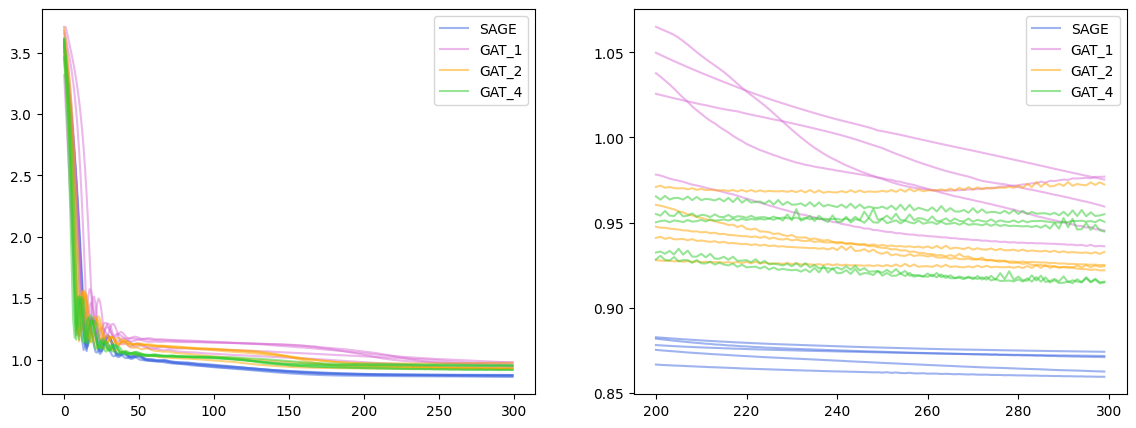

In [53]:
OFFSET = 200
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
color_list = ['royalblue', 'orchid', 'orange', 'limegreen']
assert len(results) == len(color_list)

for model, color in zip(results.keys(), color_list):
    # print(model)
    train_losses = results[model]['train_losses']
    test_losses = results[model]['test_losses']
    for i, test_loss in enumerate(test_losses):
        if i == 0:
            ax0.plot(test_loss, label=model, c=color, alpha=0.5)
            ax1.plot(range(OFFSET, len(test_loss)), test_loss[OFFSET:], label=model, c=color, alpha=0.5)
        else:
            ax0.plot(test_loss, c=color, alpha=0.5)
            ax1.plot(range(OFFSET, len(test_loss)), test_loss[OFFSET:], c=color, alpha=0.5)

ax0.legend()
ax1.legend()
plt.show()

In [73]:
POOL_SIZE = 3
model_losses, model_training_times, model_names = [], [], []
for model, color in zip(results.keys(), color_list):
    test_losses = results[model]['test_losses']
    train_durations = results[model]['time_elapsed']
    
    avg_final_test_losses, avg_train_durations = [], []
    for test_loss in test_losses:
        avg_final_test_losses.append(sum(test_loss[-POOL_SIZE:]) / POOL_SIZE)
        avg_train_durations.append(sum(train_durations) / len(train_durations))
    
    model_names.append(model)
    model_losses.append(avg_final_test_losses)
    model_training_times.append(avg_train_durations)

# model_names, model_losses

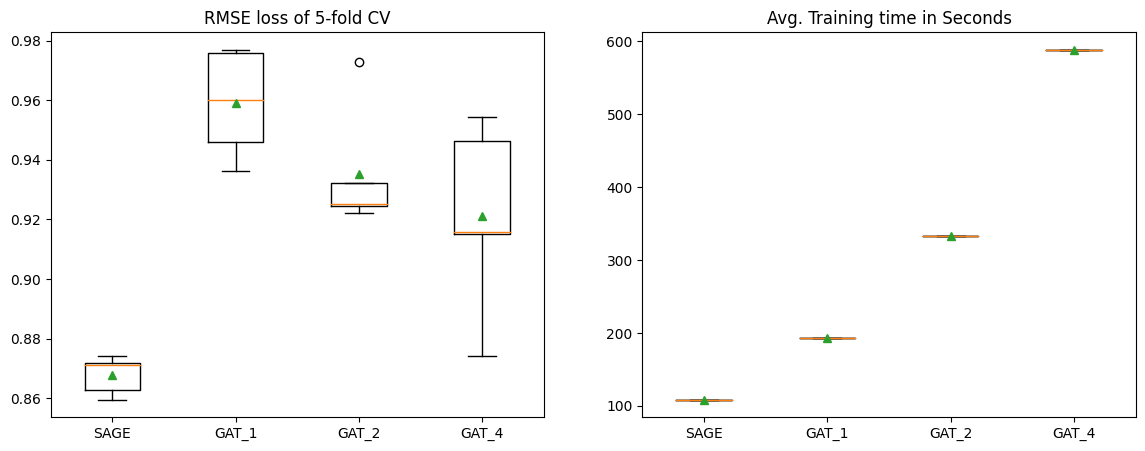

In [75]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

ax0.boxplot(model_losses, labels=model_names, showmeans=True)
ax0.set_title('RMSE loss of 5-fold CV')
ax1.boxplot(model_training_times, labels=model_names, showmeans=True)
ax1.set_title('Avg. Training time in Seconds')
plt.show()